# Техническое задание Libertex - Makarov Egor 

## Краткое вступление

Привет, спасибо большое за возможность выполнить это тестовое задание. Забегая вперед скажу, что оно мне понравилось и я получил удовольствие решая его.

В этом файле находится мое решение. Я делал очень много текстовых пометок, пытаясь обьяснить свою логику. Таким образом я хочу показать свой ход мыслей и в случае чего, можно будет понять на каком этапе я повернул "не туда" если такое будет (надеюсь нет). 

Начинаем наш storytelling по данным

### Описание задания

Let's imagine mobile application that receives traffic from different sources. This traffic is not homogeneous and we need to know it better in order to optimize marketing activity

Your task is to analyze dataset in order to find useful insights: what segments of data bring traffic with the best quality 
(Main metric is conversion rate from lead to client. There can be other metrics as well) 


You can do this by answering following questions:
-How users are distributed over countries?
-How many outliers are there in data (in terms of deposits)?
-Find segments with best conversion rate (client/lead ratio) and explain why you consider them best ones
-Visualize deposits distribution over sources and channels
-What are your advices to marketing team in order to optimize their activity?

To do this you have a synthetic dataset that contains history of users' activities (registrations and deposits)
Data description: client_id - unique id of lead/client. it's assigned during registration and isn't changed anymore 
Country - country of lead/client (iso2). It's in the separate file (countries.csv)
Source - source of traffic acquisition. There are two possible sources (posts and telegram channel). 
	if Source contains "postid" - it means that lead came from article. id of post doesn't matter. if Source contains "telegram" - it means that lead came from telegram  
channel - channel of traffic. For example, user can come from 'telegram' source and from 'affiliate' channel
Clicks - amount of clicks user made during first day after registration
Latency - time of application loading in miliseconds
Depo - amount of deposit, USD



Expected result is Jupyter notebook with Python code showing answers to questions above

Glossary:
Lead: user who registered inside mobile app
Client: user who registered inside mobile app AND made a deposit

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, datetime
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Создание ссылок и загрузка файлов. В url вставьте путь к своим файлам


In [2]:
url = "C:/Users/egork/Desktop/Data Science/Technical tasks/Libertex/countries.csv"
url_2 = "C:/Users/egork/Desktop/Data Science/Technical tasks/Libertex/synthetic_data.csv"

In [3]:
df_countries = pd.read_csv(url)
df_synthetic = pd.read_csv(url_2, index_col = 'Unnamed: 0')

### Меняю название колонки по тз

In [4]:
df_synthetic['segment'] = df_synthetic['segment'].apply(lambda x: 'article' if x.startswith('postid') else x)
df_synthetic.rename(columns = {'segment':'source'}, inplace = True)

### Проверяю на отсутствующие данные 

In [5]:
df_null = df_synthetic.isnull()

In [6]:
for column in df_null.columns.values.tolist():
    print(column)
    print(df_null[column].value_counts())
    print(' ')


depo
False    219314
Name: depo, dtype: int64
 
source
False    219314
Name: source, dtype: int64
 
channel
False    217142
True       2172
Name: channel, dtype: int64
 
clicks
False    219314
Name: clicks, dtype: int64
 
latency
False    219314
Name: latency, dtype: int64
 
client_id
False    219314
Name: client_id, dtype: int64
 


### Смотрю откуда приходят пустые данные и что с ними делать 

In [7]:
df_synthetic[df_synthetic['channel'].isnull()].head()

,depo,source,channel,clicks,latency,client_id
222,0,article,NaN,0.0,3.513545,7775021
276,0,telegram,NaN,1.0,3.813109,5505050
526,0,article,NaN,16.0,2.278295,1386781
693,0,telegram,NaN,15.0,4.355817,5899764
826,0,article,NaN,14.0,3.904059,2809769


In [8]:
df_synthetic[df_synthetic['channel'].notna()].head()

,depo,source,channel,clicks,latency,client_id
0,0,article,smm,1.0,2.649725,1442498
1,0,telegram,affiliate,10.0,2.610846,7865631
2,0,article,facebook,13.0,3.001162,8165584
3,0,telegram,direct,0.0,1.788369,5893056
4,0,telegram,smm,0.0,1.932069,3780924


In [9]:
df_synthetic['channel'].value_counts().to_frame()

,channel
facebook,76516
smm,65805
social media,42250
direct,21714
affiliate,10857


Пока никаких инсайтов по NaN я не нашел. Реплейсить не буду, так как нет уверенности в том, чем реплейсить, хотя идеей было вставить other. Удалять пока тоже не буду, так как отсутствуют только показатели канала и сильно на нашу аналитику это не повлияет.

### Создание единого DataFrame

In [10]:
df = df_synthetic.merge(df_countries, how='inner', on='client_id').drop(columns = 'client_id')
df['depo'] = df['depo'].astype(float)

### После объединения я пошел смотреть распределение депозитов. Нулевые значения в распределение не брал.

In [11]:
df_depo = df[df['depo'] != 0]
bins = np.linspace(min(df_depo['depo']), max(df_depo['depo']), 4)
group_names = ['Low', 'Medium', 'High']
df_depo['depo-binned'] = pd.cut(df_depo['depo'], bins, labels = group_names, include_lowest = True)

C:\Users\egork\AppData\Local\Temp/ipykernel_18776/1474980900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_depo['depo-binned'] = pd.cut(df_depo['depo'], bins, labels = group_names, include_lowest = True)


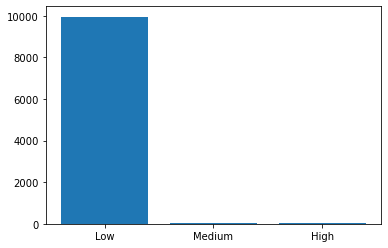

In [12]:
#Распределение по бинам
plt.bar(group_names, df_depo['depo-binned'].value_counts());

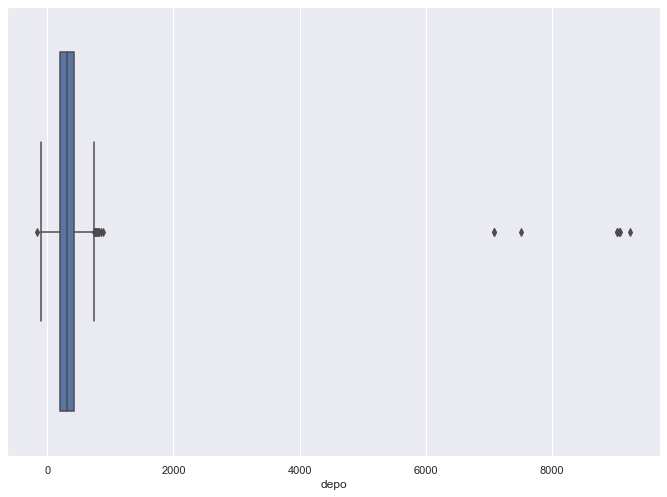

In [13]:
#Боксплот нижнего уровня. Даже тут видно, что большинство данных находится в диапазоне от 0 до 500
#Видно большое количество аномалий даже для нижнего уровня
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(data=df_depo[df_depo['depo-binned'] == 'Low'], x='depo');

In [14]:
#Колво бинов
print(bins)
df_depo['depo-binned'].value_counts().to_frame()

[ -164.  9733. 19630. 29527.]


,depo-binned
Low,9953
Medium,50
High,30


In [15]:
#Таблица со средним и высшим уровнями. Никаких обьединяющих признаков
df_depo[(df_depo['depo-binned'] == 'Medium') | (df_depo['depo-binned'] == 'High')].sort_values(by='depo', ascending=False)[:30:2]

,depo,source,channel,clicks,latency,country,depo-binned
146921,29527.0,telegram,facebook,0.0,2.529015,ES,High
139552,28035.0,telegram,social media,28.0,0.144567,MO,High
139776,27221.0,telegram,social media,15.0,1.690234,LT,High
160424,24768.0,article,direct,0.0,5.700645,LU,High
177316,24305.0,telegram,smm,15.0,2.597695,DE,High
163562,24180.0,article,facebook,14.0,5.193526,ES,High
37221,22868.0,article,facebook,1.0,2.952504,US,High
58196,22460.0,article,facebook,0.0,4.163367,IN,High
169701,22332.0,article,smm,5.0,4.080259,VN,High
210964,21998.0,article,facebook,17.0,3.596715,MO,High


Исходя из этого можем сделать вывод, что на просто распределение смотреть нет смысла. В задании был задан вопрос про аномалии и мы можем сказать, что у нас есть 80 случаев, когда депозиты были сделаны "не как обычно", но каких то дополнительных инсайтов из этого мы получить не можем. 99% данных находится в примерном диапазоне от 0 до 500. Остальные данные являются аномалиями без характерного признака

С общими депозитами пока разобрались. Давайте посмотрим на данные в других разрезах

Я хотел посчитать кол-во уникальных пользователей но проблема в том, что у нас нет уникальных значений id пользователя, а я не совсем понял могут ли они дублироваться или нет. Предположим, что для одного пользователя - одна строка в df. Тогда таблица ниже говорит о количестве уникальных пользователей. Если же id может дублироваться (в нашем df такого не было), то таблица будет отображать информацию по лидам

### Количество пользователей

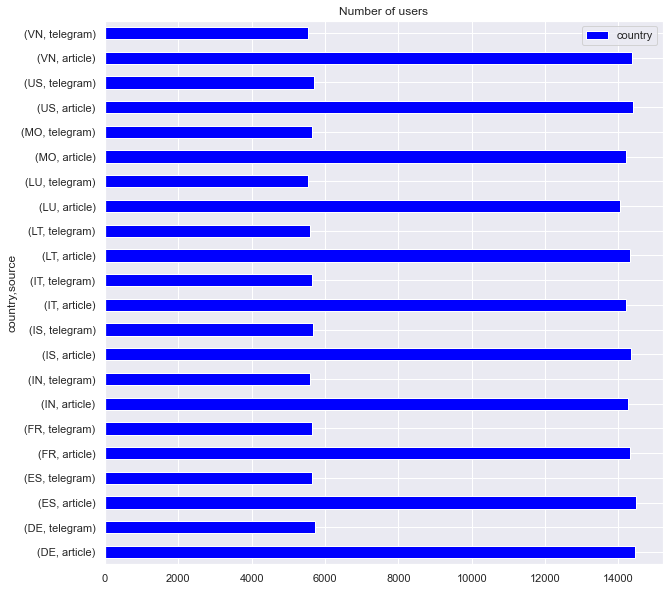

In [16]:
df.groupby(['country', 'source']).agg({'country' : 'count'}).plot(kind='barh', color = ['blue'],ax=plt.gca(), figsize=(10,10), title='Number of users');

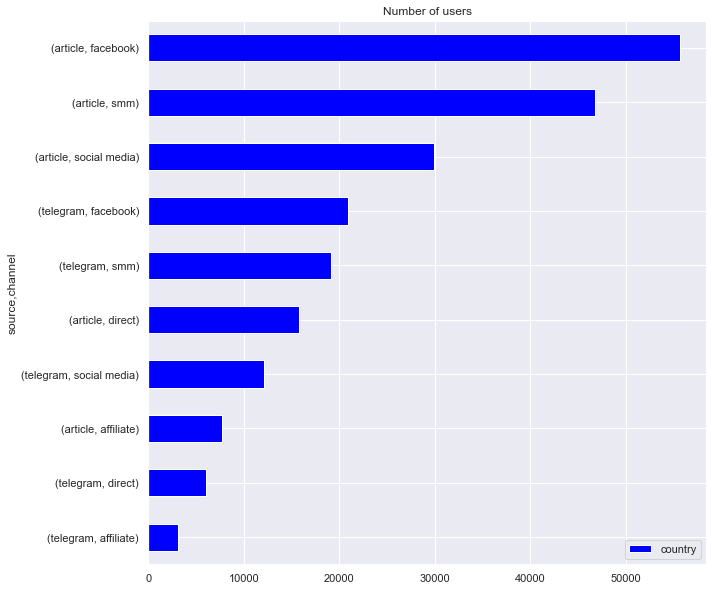

In [17]:
df.groupby(['source', 'channel']).agg({'country' : 'count'}).sort_values(by='country').plot(kind='barh', color = ['blue'],ax=plt.gca(), figsize=(10,10), title='Number of users');

Пользователи распределены равномерно по гео, что удивительно. При этом по каналам и источникам трафика у нас есть свои лидеры и аутсайдеры. 

Топ 3 занимают посты, с каналами Facebook, SMM & Social Media

Среди аутсайдеров у нас канал affiliate от обоих источников и канал direct от телеграмма

### Средняя скорость загрузки

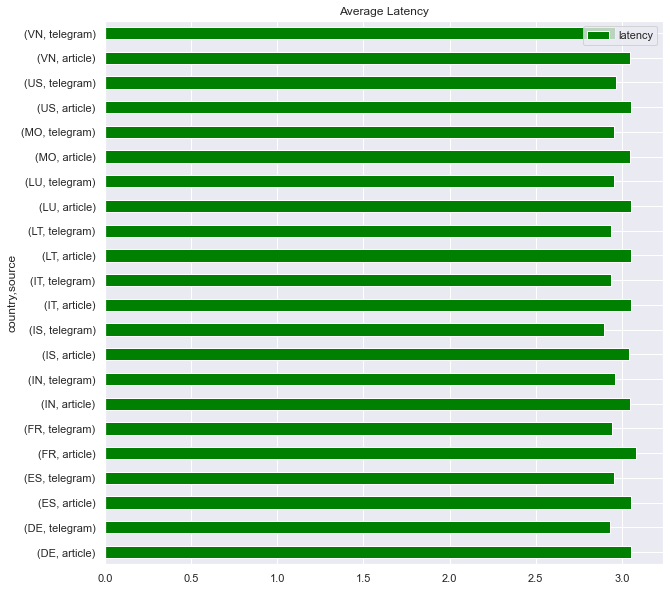

In [18]:
df.groupby(['country', 'source']).agg({'latency':'mean'}).plot(kind='barh', color = ['green'],ax=plt.gca(), figsize=(10,10), title='Average Latency');

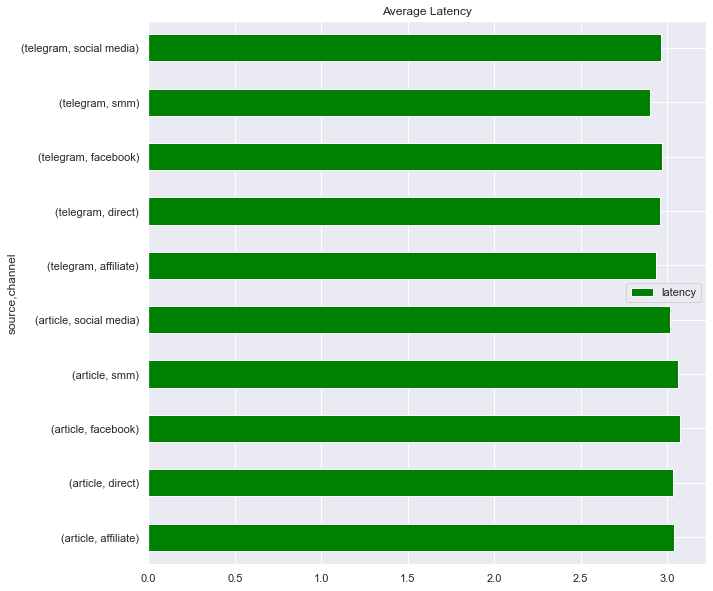

In [19]:
df.groupby(['source', 'channel']).agg({'latency':'mean'}).plot(kind='barh', color = ['green'],ax=plt.gca(), figsize=(10,10), title='Average Latency');

Скорость загрузки приложения по гео и источникам одинакова.

### Депозиты

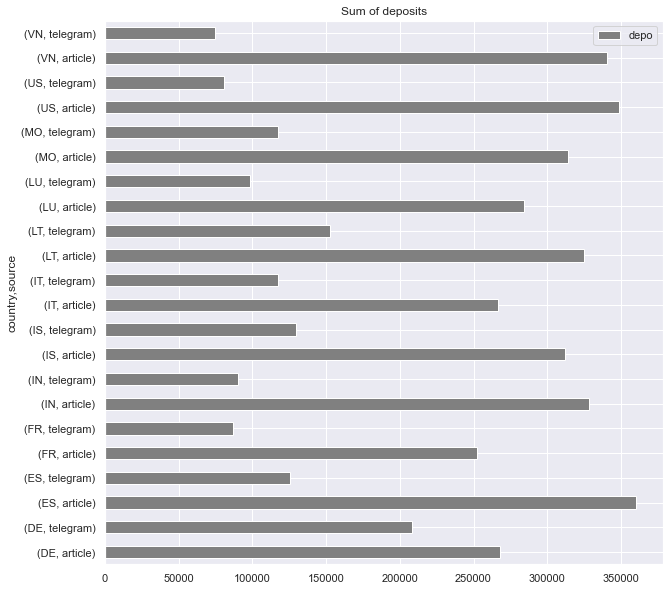

In [20]:
df.groupby(['country', 'source']).agg({'depo':'sum'}).plot(kind='barh', color = ['gray'],ax=plt.gca(), figsize=(10,10), title='Sum of deposits');

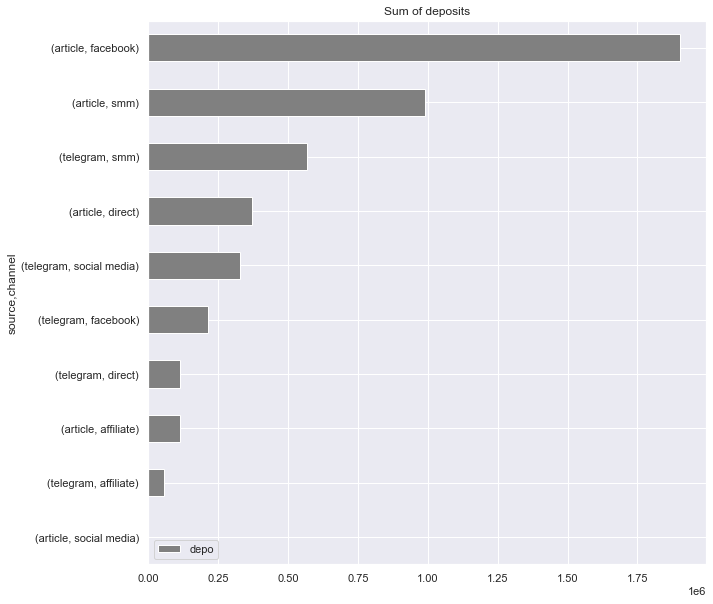

In [21]:
df.groupby(['source', 'channel']).agg({'depo':'sum'}).sort_values(by='depo').plot(kind='barh', color = ['gray'],ax=plt.gca(), figsize=(10,10), title='Sum of deposits');

Как и с графиком по пользователям мы видим равномерное распределение депозитов по гео. При этом по каналам и источникам трафика у нас так же есть свои лидеры и аутсайдеры.

Топ 3 занимают посты, с каналами Facebook & SMM а также SMM от источника телеграм. 

Social Media от постов входил в топ-3 по количеству постов,  но при этом не было совершено никаких депозитов от пользователей с этого канала также компанию аутсайдеров составят каналы affiliate от обоих источников 

### Conversion rate

Я думаю о том, что не каждый лид - клиент, но каждый клиент - лид. И так как строки здесь уникальны и не дублируют информацию, мы не можем посмотреть нормальное отношение клиентов к лидам. Есть два способа:

1. Просто посмотреть отношение клиентов к лидам, предполагая, что если пользователь клиент - он перестает быть лидом. Так я и буду делать ниже
2. Берем датафрейм без разделений и считаем, что количество пользователей в нем - это все лиды. Потом отдельно считаем сколько у нас клиентов и находим соотношение. Как я сказал выше, я пойду по первому пути

In [22]:
#Датафрейм с клиентами был определен выше. Создаем датафрейм с лидами и находим их количество
df_no_depo = df[df['depo'] == 0]
df_client = df_depo.groupby(['country', 'source']).agg({'country':'count'})
df_lead = df_no_depo.groupby(['country', 'source']).agg({'country':'count'})
#Считаем % клиентов к лидам
ctl_country = df_client/df_lead*100
ctl_country

country
country source            
DE      article   4.020137
        telegram  7.292446
ES      article   4.109786
        telegram  6.274731
FR      article   3.870452
        telegram  6.272368
IN      article   4.156622
        telegram  7.155189
IS      article   4.096753
        telegram  7.532173
IT      article   4.204270
        telegram  6.466251
LT      article   3.934950
        telegram  6.868918
LU      article   4.010378
        telegram  7.017205
MO      article   3.715871
        telegram  6.695587
US      article   4.005774
        telegram  6.988540
VN      article   3.914616
        telegram  6.877898

Если смотреть в разрезе страны и источника, то снова видим, что цифры одинаковые.

Пойдем смотреть в другом разрезе

In [23]:
df_client_1 = df_depo.groupby(['source', 'channel']).agg({'country':'count'})
df_lead_1 = df_no_depo.groupby(['source', 'channel']).agg({'country':'count'})
ctl_source = df_client_1/df_lead_1*100
ctl_source
#Article Social Media NaN потому что у нас нет клиентов из этого канала

country
source   channel                
article  affiliate      3.973510
         direct         3.971978
         facebook       6.326648
         smm            3.971656
         social media        NaN
telegram affiliate      8.425414
         direct         6.476593
         facebook       3.421770
         smm           10.785619
         social media   6.902327

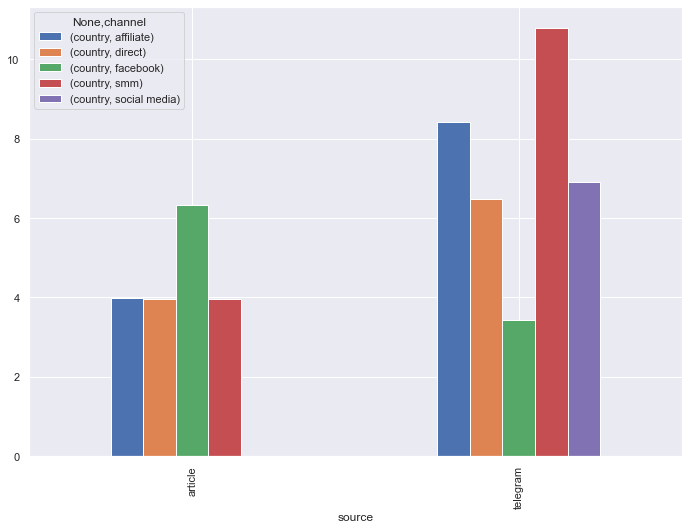

In [24]:
#Some plotting
ctl_source.sort_values('country').unstack().plot(kind='bar');

Другое дело. Мы видим, что у нас большая конверсия в клиентов по каналам affiliate/direct/smm, если они заходят через телеграм, но при этом, конверсия клиентов с facebook лучше идет через посты

### Советы для команды маркетинга

На мой взгляд самый выгодный канал привлечения пользователей является связка article+facebook.

Конверсия лида в клиента достаточно высока и равняется 6.33%

При этом пользователи из этой связки принесли больше всего денег - 1 901 796 условных единиц

Я бы не стал отдавать приоритет какому либо из регионов, так как на мой взгляд они все ведут себя примерно одинаково

Кроме того, я бы посоветовал обратить внимание на связку article + social_media. У нас пока нет информации о платящих клиентах по этой связке, но источник телеграм с этим каналом показывает довольно высокую конверсию лидов в клиенты, да и по депозитам связа telegram + social_media занимает топ-5



# Заключение

Мне было очень приятно и интересно делать аналитику по этому заданию. Датасет был обьяснен хорошо, задания были даны четко, с разрешением на ининциативность. Я так и не понял, зачем тут нужны были клики, но явно для какой то метрики с конверсией. Возможно, при успешном прохождении технического, у меня будет шанс обсудить мою аналитику с вашей командой.

Спасибо большое за возможность, надеюсь я вас не утомил

Хорошего дня/вечера :)

P.S. ниже я поигрался с кластерами, чтобы разбить пользователей машинкой, хотя Андрей и говорит, что кластеризация - это не машинное обучение 

### Импорт библиотек

In [25]:
import sklearn
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

In [26]:
# str -> 1/0
clusters = pd.get_dummies(df)

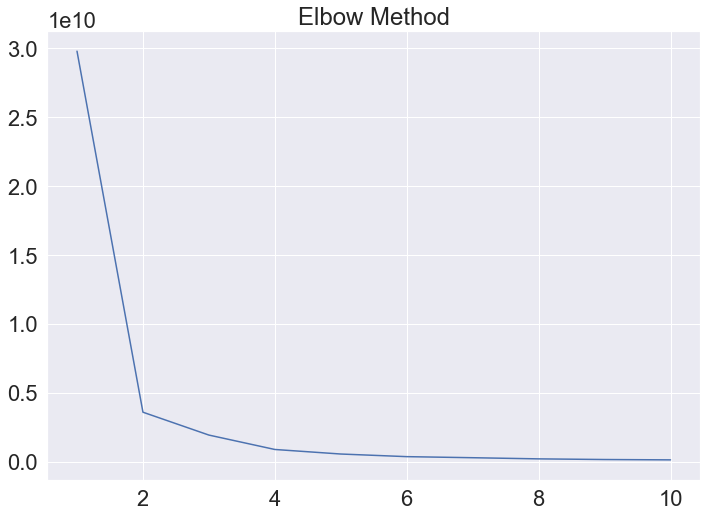

In [27]:
#Метод локтя помогает определить количество кластеров
wcss = []
for i in range(1, 11):
    clustering = KMeans(n_clusters=i, init='k-means++', random_state=50)
    clustering.fit(clusters)
    wcss.append(clustering.inertia_)
ks = range(1,11)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(font_scale = 2)
sns.lineplot(x=ks, y=wcss).set_title('Elbow Method');

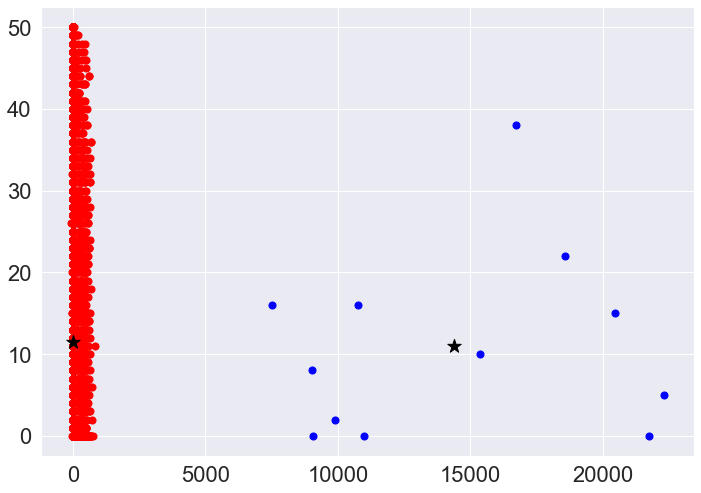

In [28]:
#Кластеризация
kdata = clusters.sample(frac = 0.15).values

km = KMeans(n_clusters=2, init = 'k-means++')
#наполняем объект
km.fit(kdata)
#центры
centers = km.cluster_centers_
#предсказываем
y_km = km.fit_predict(kdata)
#plotting
plt.scatter(kdata[y_km == 0,0], kdata[y_km == 0,1], s=50, color='red')
plt.scatter(kdata[y_km == 1,0], kdata[y_km == 1,1], s=50, color='blue')
plt.scatter(centers[0][0], centers[0][1], marker='*', s=200, color='black')
plt.scatter(centers[1][0], centers[1][1], marker='*', s=200, color='black')
plt.show()